In [1]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd
import os
import numpy as np
import matplotlib as plt

/home/sean/.pyenv/versions/3.7.0/envs/xflow/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Utils

In [56]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)
    
def load_text(path):
    import csv
    data = {}
    with open(path, 'r', encoding='utf-8') as f:
        csv_reader = csv.DictReader(f, skipinitialspace=False)
        for i, row in enumerate(csv_reader):
            if i == 0:
                for r in row:
                    data[r] = []
            data["step"].append(row["step"])
            data["runtime"].append(float(row["runtime"]))
        data["graph"] = []
    return data
            
            
def save_figure(name, path, sb_axes):
    fig = sb_axes.get_figure()
    fig.savefig(f'{path}/{name}.eps', dpi=600,  bbox_inches = "tight")
    
def get_files_from_dir(folder, ext='json'):
    paths = []
    with os.scandir(folder) as it:
        for entry in it:
            if entry.name.endswith(f".{ext}") and entry.is_file():
                paths.append((entry.path, entry.name))
    return paths

def set_seaborn_style():
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.1
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontweight='bold', fontsize=10) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

set_seaborn_style()

In [ ]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


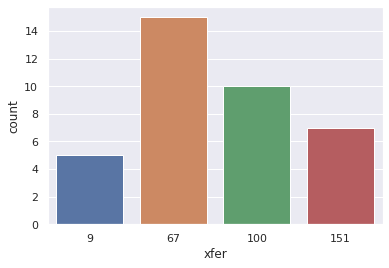

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

# Pair plot of detailed costs

In [33]:
def plot_pair_grid(graph, timestamp):
    data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[], graph=[])
    
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    
    for i, _ in enumerate(graph):
        path = f'../logs/xflowrl/{graph[i]}/{timestamp[i]}/runtime_info.json'
        detailed_costs = load_json(path)

        for e in detailed_costs:
            for k, v in e.items():
                data[k].append(v)
        data['graph'].extend([graph[i]] * len(detailed_costs))

    df = pd.DataFrame.from_dict(data)
    print(df.head())
    g = sns.PairGrid(df, hue='graph')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

    runtime     flops     mem_acc  num_kernels        graph
0  1.385149  1.315675  124.513184        21984  squeezenet1
1  1.363356  1.398332  127.303223        21986  squeezenet1
2  1.383611  1.407999  122.791748        21985  squeezenet1
3  1.414033  1.315675  124.843262        21985  squeezenet1
4  1.353070  1.404698  122.189453        21984  squeezenet1


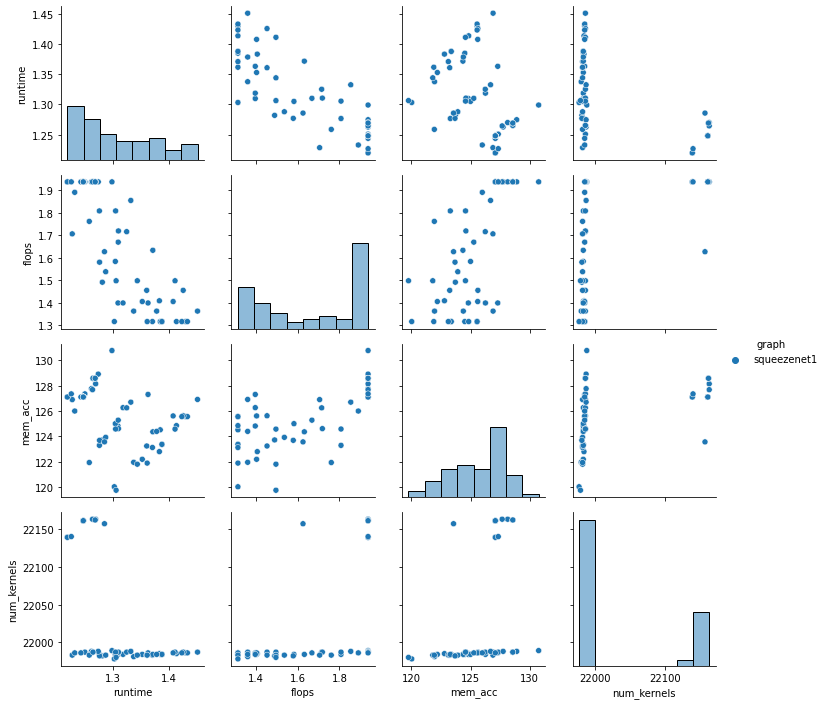

In [34]:
#graphs = ['BERT', 'squeezenet1']
#timestamps = ['20210309-161428', '20210311-184605']
#plot_pair_grid(graphs, timestamps)

plot_pair_grid('squeezenet1', '20210311-184605')

# MB controller training reward line graph

In [3]:
def plot_training_reward(graphs, save_name, fix=False, title=''):
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(dict(value=[], timestep=[], graph=[]))
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        min_v, max_v = 1e6, -1e6
        temp_vals = []
        
        for e in json_data:
            data['timestep'].append(e[1])
            temp_vals.append(e[2])
            min_v = min(min_v, e[2])
            max_v = max(max_v, e[2])
        
        if fix:
            for i in range(data['timestep'][-1] + 10, 2010, 10):
                data['timestep'].append(i)
        
        to_extend = 200 - len(temp_vals)
        if fix:
            temp_vals.extend([temp_vals[-1]] * to_extend)
            data['graph'].extend([graph] * 200)
        else:
            data['graph'].extend([graph] * len(json_data))

        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        #for i, v in enumerate(temp_vals[to_extend::10]):
        #    temp_vals[to_extend + (i * 10)] += np.random.normal(0, 1) * 5
        #data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])

        df = pd.DataFrame.from_dict(data)
        df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        all_df = pd.concat([all_df, df])
        

    # df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    ax = sns.lineplot(x='timestep', y='value', data=all_df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Normalised Reward', title=title)
    ax.legend(labels=graph_names, frameon=False)
    save_figure(save_name, '../plots', ax)

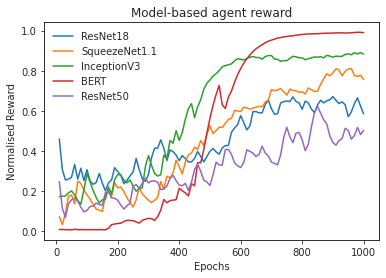

In [4]:
paths = get_files_from_dir('../chart_data/worldmodel_agent_reward')
plot_training_reward(paths, 'mb_ctrl_training_reward', title='Model-based agent reward')

# Model-free agent rewards

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


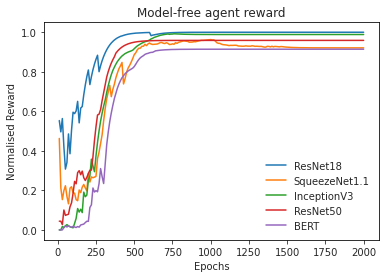

In [5]:
paths = get_files_from_dir('../chart_data/modelfree_agent_reward')
plot_training_reward(paths, 'mf_training_reward', fix=True, title='Model-free agent reward')

# World model training loss line graph

In [6]:
def plot_training_loss_world_model(paths):
    data = dict(value=[], timestep=[], graph=[])
    
    for path, file_name in paths:
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    print(df.head())
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Log-likelihood Loss', title='World Model Training Loss')
    ax.legend(labels=['BERT', 'ResNet50', 'SqueezeNet1.1', 'InceptionV3', 'ResNet18'], frameon=False)
    save_figure('mb_training_loss', '../plots', ax)

      value  timestep graph
0  0.874853        10  BERT
1  0.855583        20  BERT
2  0.492447        30  BERT
3  0.363423        40  BERT
4  0.245316        50  BERT


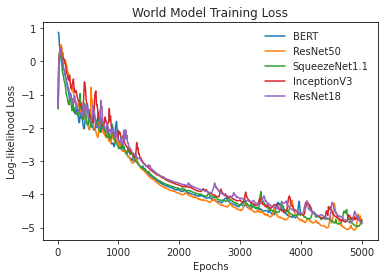

In [7]:
paths = get_files_from_dir('../chart_data/worldmodel_loss')
plot_training_loss_world_model(paths)

# Baseline methods runtimes

In [14]:
def plot_runtimes_bar_chart(paths):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'XflowRL', 'xflowrl_mb': 'XflowRL'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            for backend, obj in json_data[k]['runtime'].items():
                if backend != 'xflowrl_mf' and backend != 'xflowrl_mb':
                    data['runtime'].append(obj['mean'])
                    data['backend'].append(backend_map[backend])
                    data['graph'].append(k)
            graph_order.append(k)
            
    print(data)
    df = pd.DataFrame.from_dict(data)
    print(df.head())
    
    g = sns.catplot(x='backend', y='runtime', col='graph',
                    data=df, kind="bar", saturation=0.6, ci=None, sharey=False, aspect=0.5)
    g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16, fontweight='bold')
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    for ax in axes:
        g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')

    show_values_on_bars(axes)
    g.savefig('../plots/baseline_runtimes.eps')

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])
{'runtime': [4.6, 3.5, 3.22, 12.2, 10.37, 11.35, 26.7, 21.36, 24.96, 17.6, 14.2, 13.8, 4.1, 3.6, 2.03], 'backend': ['TensorFlow', 'TensorRT', 'TASO', 'TensorFlow', 'TensorRT', 'TASO', 'TensorFlow', 'TensorRT', 'TASO', 'TensorFlow', 'TensorRT', 'TASO', 'TensorFlow', 'TensorRT', 'TASO'], 'graph': ['squeezenet', 'squeezenet', 'squeezenet', 'resnet18', 'resnet18', 'resnet18', 'resnet50', 'resnet50', 'resnet50', 'inceptionv3', 'inceptionv3', 'inceptionv3', 'bert', 'bert', 'bert']}
   runtime     backend       graph
0     4.60  TensorFlow  squeezenet
1     3.50    TensorRT  squeezenet
2     3.22        TASO  squeezenet
3    12.20  TensorFlow    resnet18
4    10.37    TensorRT    resnet18


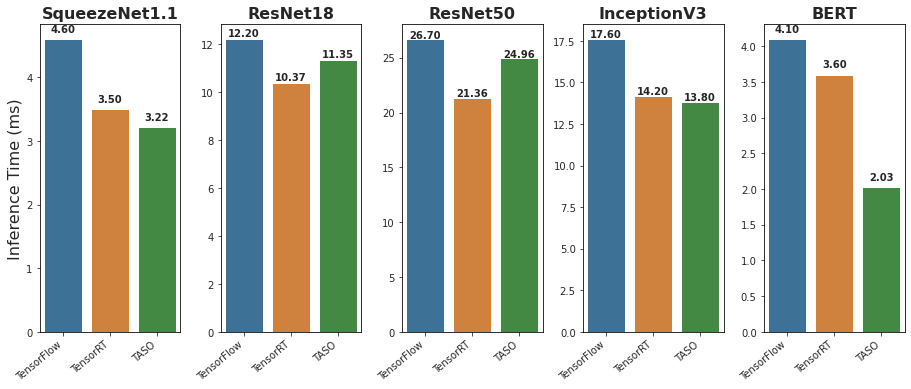

In [15]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths)

# World model reward prediction

In [19]:
def plot_reward_prediction(graphs):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(data)
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        
        arr1 = json_data['reward'][-1]
        arr2 = json_data['real_reward'][-1]
        for i in enumerate(arr1):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['pred'] * len(arr1))
        
        for i in enumerate(arr2):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['real'] * len(arr1))
        break
        
        #min_v, max_v = 1e6, -1e6
        #temp_vals = []
        #for i, e in enumerate(json_data):
        #    data['timestep'].append(i)
        #    temp_vals.append(e[2])
        #    min_v = min(min_v, e[2])
        #    max_v = max(max_v, e[2])
        #data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        #data['graph'].extend([graph] * len(json_data))
        #df = pd.DataFrame.from_dict(data)
        #df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        #all_df = pd.concat([all_df, df])
        

    df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    #g = sns.FacetGrid(df, row='sex', col='smoker')
    #g.map(sns.lineplot, 'timestep', 'tip')
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(ylim=(0, 5))
    #ax.set(xlabel='Epochs', ylabel='Normalised Reward', title='Predicted agent reward by world model for given graph')
    #ax.legend(labels=graph_names, frameon=False)
    #save_figure('mb_ctrl_training_reward', '../plots', ax)

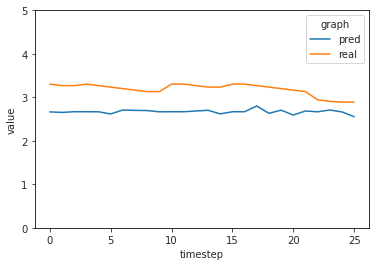

In [20]:
paths = get_files_from_dir('../results/test_reward')
plot_reward_prediction(paths)

# Model-based runtimes

In [16]:
def plot_runtimes_bar_chart(paths, exclude=[], savename=''):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'Model-free', 'xflowrl_mb': 'Model-based'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            for backend, obj in json_data[k]['runtime'].items():
                if backend in exclude:
                    continue
                data['runtime'].append(obj['mean'])
                data['backend'].append(backend_map[backend])
                data['graph'].append(k)
            graph_order.append(k)
            
    df = pd.DataFrame.from_dict(data)
    
    g = sns.catplot(x='backend', y='runtime', col='graph',
                data=df, kind="bar", saturation=0.6, ci=None, sharey=False, aspect=0.5)
    g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16, fontweight='bold')
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    for ax in axes:
        g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')

    show_values_on_bars(axes)
    g.savefig(f'../plots/runtimes_{savename}.eps')

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


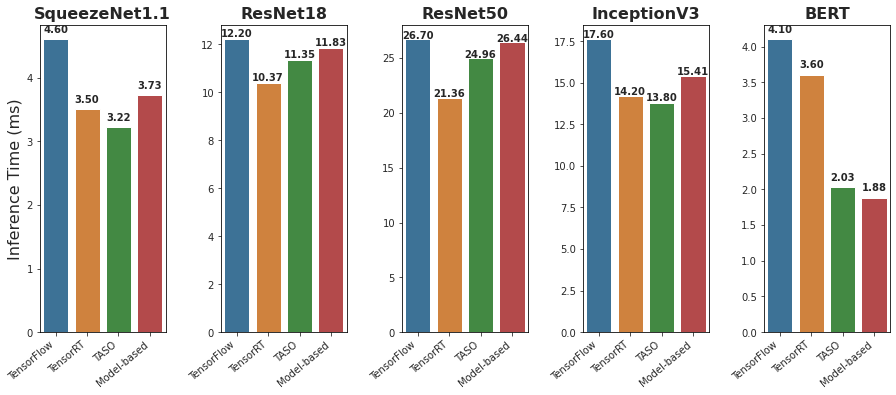

In [17]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, exclude=['xflowrl_mf'], savename='mb')

# Model-free runtimes

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


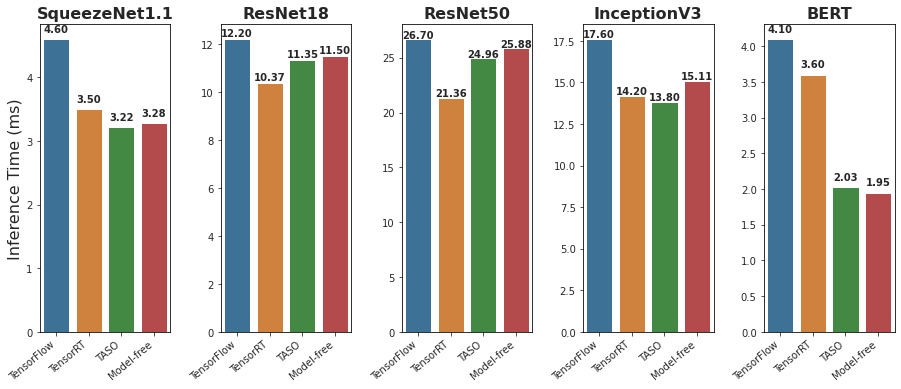

In [18]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, exclude=['xflowrl_mb'], savename='mf')

# All runtimes

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


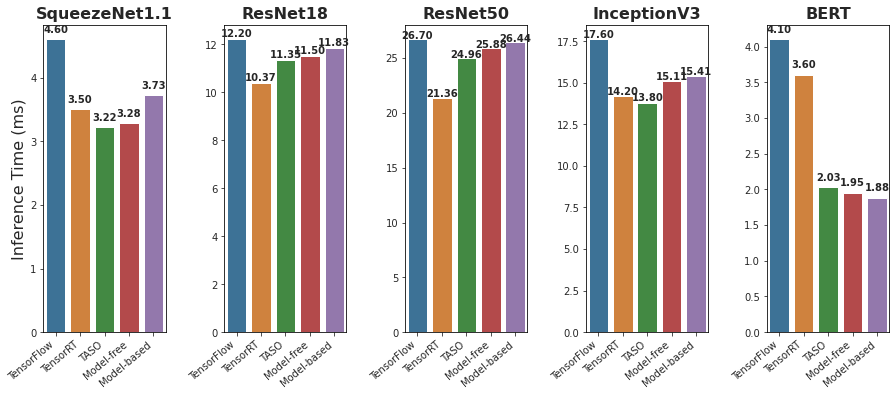

In [19]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart(paths, savename='all')

# Xfer heatmap

In [20]:
def plot_xfer_heatmap():
    xfer_id_map = {}
    xfer_applied = {
        'BERT': {'95': 24, '18': 2},
        'InceptionV3': {'13': 19},
        'SqueezeNet1.1': {'138': 7, '112': 1, '12': 8, '1': 2},
        'ResNet18': {'1': 5, '7': 4},
        'ResNet50': {'1': 17, '7': 4, '145': 1}
    }
    converted_mapping = {'xfer': [], 'graph': [], 'count': []}
    for k, v in xfer_applied.items():
        for k1, v1 in v.items():
            if k1 not in xfer_id_map:
                xfer_id_map[k1] = f's{len(xfer_id_map) + 1}'
                
            converted_mapping['xfer'].append(xfer_id_map[k1])
            converted_mapping['count'].append(int(v1))
        converted_mapping['graph'].extend([k] * len(v.items()))
    print(converted_mapping)
    
    # sorted_xfers = OrderedDict(sorted(xfer_mapping.items(), key=lambda x: int(x[0])))
    df = pd.DataFrame.from_dict(converted_mapping)
    df = df.pivot('graph', 'xfer', 'count')
    # df_formatted = df.pivot('graph', 'xfer', 'count')
    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_bad((0.97, 0.98, 1, 0.5))
    ax = sns.heatmap(df, linewidths=.5, annot=True, cmap=cmap, annot_kws={'fontweight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
    save_figure('xfer_heatmap', '../plots', ax)

/home/sean/.pyenv/versions/3.7.0/envs/xflow/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transpa

{'xfer': ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's7', 's8', 's7', 's8', 's9'], 'graph': ['BERT', 'BERT', 'InceptionV3', 'SqueezeNet1.1', 'SqueezeNet1.1', 'SqueezeNet1.1', 'SqueezeNet1.1', 'ResNet18', 'ResNet18', 'ResNet50', 'ResNet50', 'ResNet50'], 'count': [24, 2, 19, 7, 1, 8, 2, 5, 4, 17, 4, 1]}


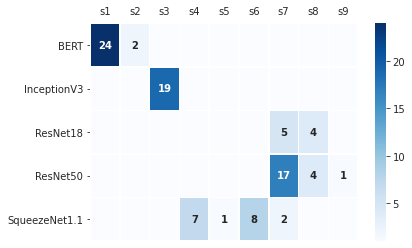

In [21]:
plot_xfer_heatmap()

# TASO training plot

In [115]:
def plot_taso_training(paths):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    graph_names = []
    limit = 50
    for path, file_name in paths:
        data1 = load_text(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        min_v, max_v = float(1e6), float(-1e6)
        temp_vals = []
        
        for e in data1['runtime']:
            temp_vals.append(e)
            min_v = min(min_v, e)
            max_v = max(max_v, e)
            
        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals[:limit]])
        data['timestep'].extend(data1['step'][:limit])
        #data['value'].extend(data1['runtime'][:50])
        data['graph'].extend([graph] * limit)

    df = pd.DataFrame.from_dict(data)
    #df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    print(df.head())
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Search step', ylabel='Normalised estimated runtime', title='TASO Backtracking Search')
    ax.legend(labels=['InceptionV3', 'SqueezeNet1.1', 'ResNet50', 'ResNet18', 'BERT'], frameon=False)
    ax.set_xticks(np.arange(0, 50, 5))
    ax.set_xticklabels([str(x * 100) for x in ax.get_xticks()])
    save_figure('taso_graph_search', '../plots', ax)

      value timestep        graph
0  1.000000        0  inceptionv3
1  0.924635        1  inceptionv3
2  0.845709        2  inceptionv3
3  0.781174        3  inceptionv3
4  0.716650        4  inceptionv3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

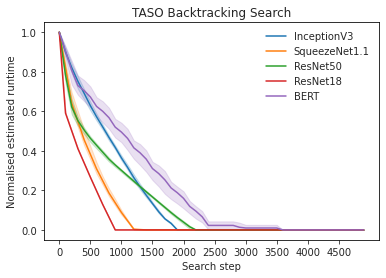

In [116]:
paths = get_files_from_dir('../chart_data/taso_training', ext='txt')
plot_taso_training(paths)